# Algorithm prototyping

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely as sh
import shapely.geometry as shg
import shapely.ops as sho
from datetime import datetime
import numpy as np

In [2]:
from pyproj import CRS, Transformer

ImportError: cannot import name 'CRS' from 'pyproj' (C:\ProgramData\Anaconda3\lib\site-packages\pyproj\__init__.py)

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils import get_sun_state, project_sunray

## Helper functions

In [6]:
crs_4326 = CRS.from_epsg(4326) # WGS84
crs_25832 = CRS.from_epsg(25832) # ETRS89 / UTM zone 32N
to_wgs_84_transformer = Transformer.from_crs(crs_25832, crs_4326)
to_utm_transformer = Transformer.from_crs(crs_4326, crs_25832)

In [7]:
df = pd.read_csv("data\extracted\dom1l-fp_32349_5660_1_nw.csv")

In [8]:
df = df.sample(100000)

In [9]:
df = gpd.GeoDataFrame(df)

In [10]:
df.head()

,x,y,z,lat,lon
4049120,349511.80,5660447.75,40.01,51.075784,6.851758
3926621,349493.66,5660079.64,46.82,51.072472,6.851652
4011340,349505.97,5660266.51,40.04,51.074154,6.851750
4774192,349644.80,5660308.70,51.83,51.074570,6.853713
3577811,349447.53,5660674.22,41.70,51.077803,6.850747


In [11]:
# creating a geometry column 
geometry = [sh.geometry.Point(xy) for xy in zip(df['lat'], df['lon'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

In [12]:
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df[["x", "y", "z"]], crs=crs, geometry=geometry)

In [13]:
gdf.head()

,x,y,z,geometry
4049120,349511.80,5660447.75,40.01,POINT (51.07578446098532 6.851757851340857)
3926621,349493.66,5660079.64,46.82,POINT (51.07247184587386 6.851652335816923)
4011340,349505.97,5660266.51,40.04,POINT (51.07415429904804 6.851750135861019)
4774192,349644.80,5660308.70,51.83,POINT (51.07456981084842 6.853712850349549)
3577811,349447.53,5660674.22,41.70,POINT (51.07780267369962 6.850746757570636)


Let's calculate the shadowing effects given an sample place

![query_example1](assets/query_example1.png)

In [14]:
lat_q, lon_q = 51.078506, 6.850453
#lat_q, lon_q = 51.078420, 6.850539
query_point = shg.Point(lat_q, lon_q)

In [15]:
# filter to 100m around query point first
R = 100
query_point_xy = shg.Point(to_utm_transformer.transform(lat_q, lon_q))
query_region_xy = query_point_xy.buffer(R, resolution=16)
query_region_wgs84 = sho.transform(to_wgs_84_transformer.transform, query_region_xy)

In [16]:
gdf_query = gdf[gdf.intersects(query_region_wgs84)]

In [17]:
len(gdf_query), len(gdf)

(3512, 100000)

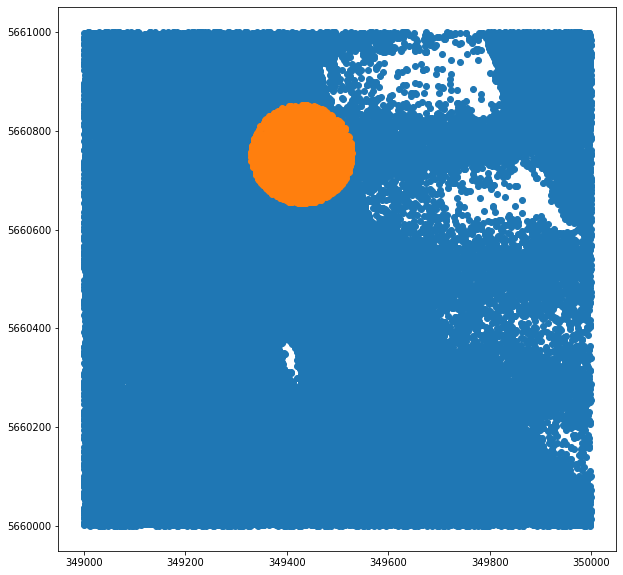

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(gdf["x"], gdf["y"])
plt.scatter(gdf_query["x"], gdf_query["y"])

In [19]:
# get nearest point to the query point
query_nearest_point = gdf_query.loc[gdf_query.distance(sh.geometry.Point(lat_q, lon_q)).idxmin()]

In [20]:
print(gdf_query.distance(sh.geometry.Point(lat_q, lon_q)).min())

9.778417646816282e-06


This point is now the origin of the projected axis, so we have to remove the offset of other points

In [21]:
query_nearest_point

x                                                349429
y                                           5.66075e+06
z                                                 41.89
geometry    POINT (51.07850283639551 6.850443747483674)
Name: 3431310, dtype: object

In [22]:
gdf_query["x_proj"] = gdf_query["x"] - query_nearest_point["x"]
gdf_query["y_proj"] = gdf_query["y"] - query_nearest_point["y"]
gdf_query["z_proj"] = gdf_query["z"] - query_nearest_point["z"]

c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\kopyt\.virtualenvs\height-map-jyag_ntc\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [23]:
gdf_query.head()

,x,y,z,geometry,x_proj,y_proj,z_proj
3577811,349447.53,5660674.22,41.70,POINT (51.07780267369962 6.850746757570636),18.95,-78.47,-0.19
3868908,349486.09,5660723.78,39.31,POINT (51.07825813811726 6.851276179891687),57.51,-28.91,-2.58
3415789,349426.55,5660733.66,42.02,POINT (51.07833129927077 6.850422716552992),-2.03,-19.03,0.13
3253166,349403.21,5660756.18,41.56,POINT (51.07852753974162 6.850080384500673),-25.37,3.49,-0.33
3504640,349437.87,5660710.96,41.92,POINT (51.07813028644231 6.850593653928947),9.29,-41.73,0.03


## Sunstate

In [24]:
query_time = datetime(2019, 7, 21, 8, 0, 0)

In [25]:
zen, azimuth = get_sun_state(lat_q, lon_q, query_time)
print(zen, azimuth)

52.26311668556522 104.69037607746418


In [26]:
P = gdf_query[["x_proj", "y_proj", "z_proj"]].values

In [27]:
R = project_sunray(P, zen, azimuth)

In [28]:
# remove all points with negative x, since they are behind the query point
R_view = R[R[:, 0] >= 0]

In [29]:
# remove all points with z>0.15m
R_view = R_view[R_view[:, 2] >= 0.15]

In [30]:
# remove all points where z sunray < 0
#R_view = R[R[:, 2] >= 0]

In [31]:
# now we only plot, y and z axis

(-100, 100)

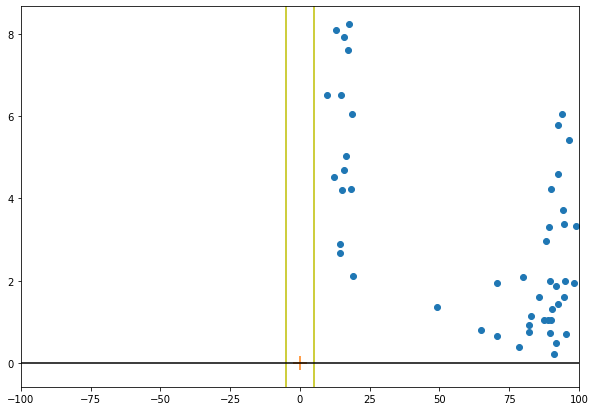

In [35]:
# now we only plot, y and z axis
plt.figure(figsize=(10,7))
plt.scatter(R_view[:, 1], R_view[:, 2])
plt.scatter(0, 0, s=200, marker="+")
plt.axvline(-5, color="y")
plt.axvline(5, color="y")
plt.axhline(0, color="k")
plt.xlim([-100, 100])

In [36]:
print(query_point_xy)

POINT (349429.2383254333 5660753.022833056)


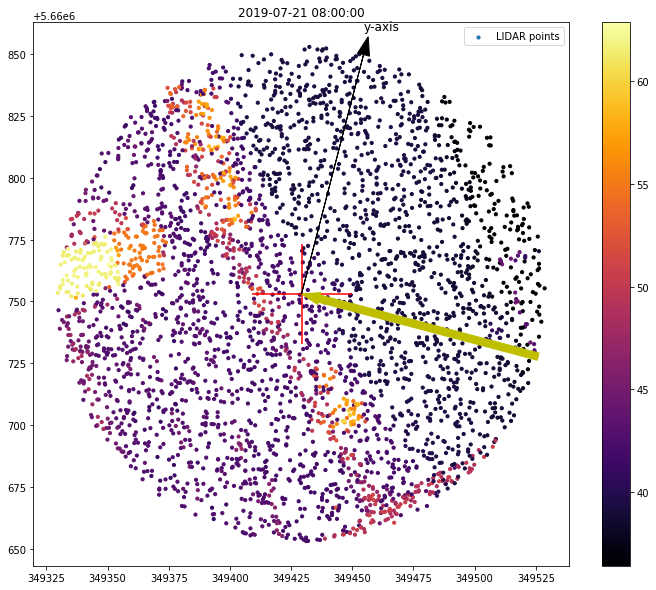

In [37]:
plt.figure(figsize=(12,10))
plt.scatter(gdf_query["x"], gdf_query["y"], c=gdf_query["z"], s=10, cmap="inferno", label="LIDAR points")
plt.colorbar()
plt.scatter([query_point_xy.x], [query_point_xy.y], marker='+', s=10000, color="red")
dx = 100*np.sin(azimuth*2*np.pi/360)
dy = 100*np.cos(azimuth*2*np.pi/360)
plt.arrow(query_point_xy.x+dx, query_point_xy.y+dy, -dx, -dy, width=3, head_width=5, length_includes_head=True, color="y", label="sun ray")
plt.arrow(query_point_xy.x, query_point_xy.y, -dy, +dx, head_width=5, length_includes_head=False, color="k")
plt.text(query_point_xy.x-dy, query_point_xy.y+dx+10, "y-axis", fontsize=12)
plt.title(query_time)
plt.legend()